In [1]:
from packaging import version
import tensorflow as tf

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

import matplotlib.pyplot as plt
import numpy as np
import json

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input 

import pandas as pd
import random

from numba import cuda 
import TensorBoardCallBackHelper as tbh

TensorFlow version:  2.4.1


### Main settings


In [2]:
# Supress scientific notation on Numpy 
np.set_printoptions(suppress=True)

# Avoid OOM on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
None
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.allow_growth = True # don't pre-allocate memory; allocate as-needed
    tf.config.experimental.per_process_gpu_memory_fraction = 0.95 # limit memory to be allocated

In [3]:
IMAGENETTE_TRAIN_PATH  = 'D:\\MyWorkSpace\\dcu_cv_assignment_ee544\\datasets\\imagenette_4class\\train'
IMAGENETTE_VALIDATION_PATH  = 'D:\\MyWorkSpace\\dcu_cv_assignment_ee544\\datasets\\imagenette_4class\\validation'
IMAGENETTE_TEST_PATH  = 'D:\\MyWorkSpace\\dcu_cv_assignment_ee544\\datasets\\imagenette_4class\\test'
EPOCHS = 30
RUN_EVERYTHING = False

### Data reading: Shuffle and data augumentation only in the training set.

In [4]:
def CreateImageDataGenerators(target_size,batch_size, use_data_aug = True):

    #For baseline version, trained without data augumentation
    trainDataGen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    if (use_data_aug == True):
        display("This is using data augumentation.")
        trainDataGen = ImageDataGenerator(
            preprocessing_function=preprocess_input, 
            #The vgg16.preprocess_input function rescales the pixel value between +1 and -1 so there is no need to include rescale=1/255. 
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest'
        )
    else:
        display("This is NOT using data augumentation!")

    validationDataGen = ImageDataGenerator(
        preprocessing_function=preprocess_input #The vgg16.preprocess_input function rescales the pixel value between +1 and -1 so there is no need to include rescale=1/255. 
    ) 

    testDataGen = ImageDataGenerator(
        preprocessing_function=preprocess_input #The vgg16.preprocess_input function rescales the pixel value between +1 and -1 so there is no need to include rescale=1/255. 
    )

    train_images = trainDataGen.flow_from_directory(
        directory=IMAGENETTE_TRAIN_PATH,
        target_size=(target_size,target_size),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        batch_size=batch_size,
    )

    validation_images = validationDataGen.flow_from_directory(
        directory=IMAGENETTE_VALIDATION_PATH,
        target_size=(target_size,target_size),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False,
        batch_size=batch_size,
    )

    test_images = validationDataGen.flow_from_directory(
        directory=IMAGENETTE_TEST_PATH,
        target_size=(target_size,target_size),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False,
        batch_size=batch_size,
    )

    return train_images, validation_images, test_images

In [5]:
def getModelVGG16_Baseline(input_shape):
    model = keras.Sequential(
        [
            layers.Input(shape=input_shape),

            layers.Conv2D(filters=32,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv1",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)),
            layers.Conv2D(filters=32,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv2",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)),
            layers.MaxPooling2D(pool_size=(2,2), name="MaxPool1"),
 
            layers.Conv2D(filters=64,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv3",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)),
            layers.Conv2D(filters=64,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv4",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)),
            layers.MaxPooling2D(pool_size=(2,2), name="MaxPool2"),
 
            layers.Flatten(name="Flatten1"),
            layers.Dense(512,kernel_initializer="glorot_uniform",name="FC1"),
            layers.Dense(4, activation="softmax", name="output",kernel_initializer="glorot_uniform"),
        ]
    )
    return model

'This is NOT using data augumentation!'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
  1/150 [..............................] - ETA: 0s - loss: 17.5134 - categorical_accuracy: 0.1875WARNING:tensorflow:From C:\Users\Pijama4WD\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
150/150 [==============================] - 125s 836ms/step - loss: 161.0804 - categorical_accuracy: 0.2604 - val_loss: 1.3853 - val_categorical_accuracy: 0.2500
Epoch 2/30
150/150 [==============================] - 112s 750ms/step - loss: 1.3647 - categorical_accuracy: 0.3196 - val_loss: 1.3306 - val_categorical_accuracy: 0.4000
Epoch 3/30
150/150 [==============================] - 109s 724ms/step - loss: 1.3071 - categorical_accuracy: 0.3931 - val_loss: 1.2844 - val_categorica

### Training time: 1363.48s

13/13 [==============================] - 1s 73ms/step - loss: 4.1535 - categorical_accuracy: 0.4525


Model     Time  F1Score                      Loss  Epochs  \
0  logs/0_baseline  1363.48     0.45  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.32                   0.9      4.15   

   val_categorical_accuracy  
0                      0.45

precision  recall  f1-score   support
church          0.341463  0.2800  0.307692  100.0000
garbage_truck   0.432990  0.4200  0.426396  100.0000
gas_pump        0.369748  0.4400  0.401826  100.0000
parachute       0.656863  0.6700  0.663366  100.0000
accuracy        0.452500  0.4525  0.452500    0.4525
macro avg       0.450266  0.4525  0.449820  400.0000
weighted avg    0.450266  0.4525  0.449820  400.0000

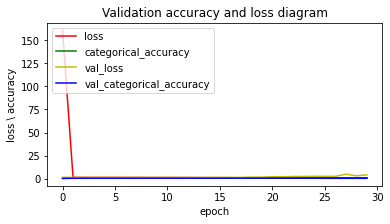

In [6]:
#BASELINE VERSION: Original image size, NO data augumentation

train_images, validation_images, test_images = CreateImageDataGenerators(224, 32, use_data_aug = False)
model = getModelVGG16_Baseline(input_shape=(224,224,3)) 
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['categorical_accuracy'])

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/baseline", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])

In [5]:
def getModelVGG16(input_shape, batchNorm = True, dropout = 0.2, denseLayersSize = 512):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(filters=32,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv1",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=32,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv2",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPool1"))
    if (dropout > 0):
        model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(filters=64,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv3",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=64,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv4",kernel_initializer="glorot_uniform", padding='same',strides=(1,1)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPool2"))
    if (dropout > 0):
        model.add(layers.Dropout(dropout))

    model.add(layers.Flatten(name="Flatten1"))
    model.add(layers.Dense(denseLayersSize,kernel_initializer="glorot_uniform",name="FC1"))
    if (dropout > 0):
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(4, activation="softmax", name="output",kernel_initializer="glorot_uniform"))

    return model

In [8]:
#Get generators with the TRAIN with data augumentation
train_images, validation_images, test_images = CreateImageDataGenerators(224, 32, use_data_aug = True)

'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


Epoch 1/30
150/150 [==============================] - 99s 658ms/step - loss: 294.2178 - categorical_accuracy: 0.4254 - val_loss: 2.9952 - val_categorical_accuracy: 0.3725
Epoch 2/30
150/150 [==============================] - 91s 605ms/step - loss: 1.5034 - categorical_accuracy: 0.3808 - val_loss: 1.2408 - val_categorical_accuracy: 0.4525
Epoch 3/30
150/150 [==============================] - 78s 521ms/step - loss: 1.5166 - categorical_accuracy: 0.4067 - val_loss: 1.2520 - val_categorical_accuracy: 0.4000
Epoch 4/30
150/150 [==============================] - 90s 600ms/step - loss: 1.5996 - categorical_accuracy: 0.4285 - val_loss: 1.1777 - val_categorical_accuracy: 0.4775
Epoch 5/30
150/150 [==============================] - 77s 516ms/step - loss: 1.4827 - categorical_accuracy: 0.4369 - val_loss: 1.1853 - val_categorical_accuracy: 0.4600
Epoch 6/30
150/150 [==============================] - 85s 564ms/step - loss: 1.2913 - categorical_accuracy: 0.4750 - val_loss: 1.1494 - val_categorical_a

### Training time: 2462.82s

13/13 [==============================] - 1s 69ms/step - loss: 0.8689 - categorical_accuracy: 0.7225


Model     Time  F1Score                      Loss  Epochs  \
0  logs/1_noBN_noDO_512  2462.82     0.72  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.73                  0.74      0.87   

   val_categorical_accuracy  
0                      0.72

precision  recall  f1-score   support
church          0.567901  0.9200  0.702290  100.0000
garbage_truck   0.877193  0.5000  0.636943  100.0000
gas_pump        0.680851  0.6400  0.659794  100.0000
parachute       0.954023  0.8300  0.887701  100.0000
accuracy        0.722500  0.7225  0.722500    0.7225
macro avg       0.769992  0.7225  0.721682  400.0000
weighted avg    0.769992  0.7225  0.721682  400.0000

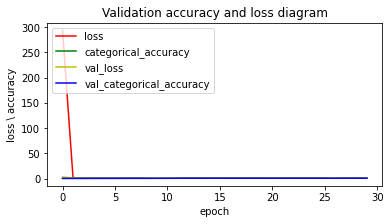

In [9]:
model = getModelVGG16((224,224,3), batchNorm = False, dropout = 0, denseLayersSize = 512)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/noBN_noDO_512", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


Epoch 1/30
150/150 [==============================] - 94s 624ms/step - loss: 144.6952 - categorical_accuracy: 0.5265 - val_loss: 7.1245 - val_categorical_accuracy: 0.5100
Epoch 2/30
150/150 [==============================] - 74s 491ms/step - loss: 5.9721 - categorical_accuracy: 0.4967 - val_loss: 7.7739 - val_categorical_accuracy: 0.5100
Epoch 3/30
150/150 [==============================] - 85s 568ms/step - loss: 5.0929 - categorical_accuracy: 0.5306 - val_loss: 3.9628 - val_categorical_accuracy: 0.6075
Epoch 4/30
150/150 [==============================] - 87s 579ms/step - loss: 4.4802 - categorical_accuracy: 0.5800 - val_loss: 3.9462 - val_categorical_accuracy: 0.6225
Epoch 5/30
150/150 [==============================] - 71s 473ms/step - loss: 3.9783 - categorical_accuracy: 0.5896 - val_loss: 5.4514 - val_categorical_accuracy: 0.5350
Epoch 6/30
150/150 [==============================] - 92s 610ms/step - loss: 3.6323 - categorical_accuracy: 0.6052 - val_loss: 3.3996 - val_categorical_a

### Training time: 2099.25s

13/13 [==============================] - 1s 72ms/step - loss: 0.8551 - categorical_accuracy: 0.7350


Model     Time  F1Score                      Loss  Epochs  \
0  logs/2_BN_noDO_512  2099.25     0.74  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.51                  0.81      0.86   

   val_categorical_accuracy  
0                      0.74

precision  recall  f1-score  support
church          0.534091   0.940  0.681159  100.000
garbage_truck   0.927273   0.510  0.658065  100.000
gas_pump        0.783133   0.650  0.710383  100.000
parachute       0.976744   0.840  0.903226  100.000
accuracy        0.735000   0.735  0.735000    0.735
macro avg       0.805310   0.735  0.738208  400.000
weighted avg    0.805310   0.735  0.738208  400.000

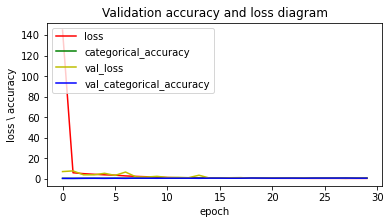

In [10]:
model = getModelVGG16((224,224,3), batchNorm = True, dropout = 0, denseLayersSize = 512)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_noDO_512", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


Epoch 1/30
150/150 [==============================] - 130s 867ms/step - loss: 182.9876 - categorical_accuracy: 0.3256 - val_loss: 1.3697 - val_categorical_accuracy: 0.3775
Epoch 2/30
150/150 [==============================] - 217s 1s/step - loss: 1.7016 - categorical_accuracy: 0.2590 - val_loss: 1.3870 - val_categorical_accuracy: 0.2500
Epoch 3/30
150/150 [==============================] - 207s 1s/step - loss: 1.3998 - categorical_accuracy: 0.2594 - val_loss: 1.3538 - val_categorical_accuracy: 0.3475
Epoch 4/30
150/150 [==============================] - 203s 1s/step - loss: 1.5387 - categorical_accuracy: 0.2679 - val_loss: 1.3609 - val_categorical_accuracy: 0.3675
Epoch 5/30
150/150 [==============================] - 211s 1s/step - loss: 1.5514 - categorical_accuracy: 0.2806 - val_loss: 1.3684 - val_categorical_accuracy: 0.3350
Epoch 6/30
150/150 [==============================] - 195s 1s/step - loss: 1.4470 - categorical_accuracy: 0.2958 - val_loss: 1.3589 - val_categorical_accuracy: 

### Training time: 4986.82s

13/13 [==============================] - 1s 82ms/step - loss: 0.9161 - categorical_accuracy: 0.6175


Model     Time  F1Score                      Loss  Epochs  \
0  logs/3_noBN_DO05_512  4986.82     0.59  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.87                  0.68      0.92   

   val_categorical_accuracy  
0                      0.62

precision  recall  f1-score   support
church          0.536145  0.8900  0.669173  100.0000
garbage_truck   0.840000  0.2100  0.336000  100.0000
gas_pump        0.520270  0.7700  0.620968  100.0000
parachute       0.983607  0.6000  0.745342  100.0000
accuracy        0.617500  0.6175  0.617500    0.6175
macro avg       0.720005  0.6175  0.592871  400.0000
weighted avg    0.720005  0.6175  0.592871  400.0000

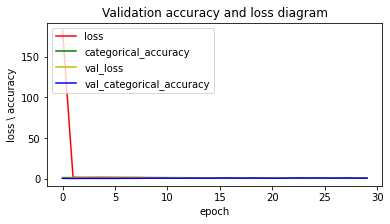

In [11]:
model = getModelVGG16((224,224,3), batchNorm = False, dropout = 0.5, denseLayersSize = 512)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/noBN_DO05_512", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


Epoch 1/30
150/150 [==============================] - 121s 806ms/step - loss: 207.4914 - categorical_accuracy: 0.5160 - val_loss: 254.3858 - val_categorical_accuracy: 0.5175
Epoch 2/30
150/150 [==============================] - 95s 635ms/step - loss: 73.8992 - categorical_accuracy: 0.5748 - val_loss: 60.7183 - val_categorical_accuracy: 0.6625
Epoch 3/30
150/150 [==============================] - 109s 725ms/step - loss: 27.3110 - categorical_accuracy: 0.5833 - val_loss: 17.0569 - val_categorical_accuracy: 0.5075
Epoch 4/30
150/150 [==============================] - 97s 650ms/step - loss: 9.7911 - categorical_accuracy: 0.5698 - val_loss: 6.1505 - val_categorical_accuracy: 0.6450
Epoch 5/30
150/150 [==============================] - 119s 793ms/step - loss: 6.4949 - categorical_accuracy: 0.5829 - val_loss: 4.1826 - val_categorical_accuracy: 0.6925
Epoch 6/30
150/150 [==============================] - 111s 737ms/step - loss: 5.3501 - categorical_accuracy: 0.5819 - val_loss: 5.0009 - val_cat

### Training time: 3153.74s

13/13 [==============================] - 1s 81ms/step - loss: 0.8948 - categorical_accuracy: 0.7025


Model     Time  F1Score                      Loss  Epochs  \
0  logs/4_BN_DO05_512  3153.74     0.71  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.59                  0.79      0.89   

   val_categorical_accuracy  
0                       0.7

precision  recall  f1-score   support
church          0.484848  0.9600  0.644295  100.0000
garbage_truck   0.960784  0.4900  0.649007  100.0000
gas_pump        0.864407  0.5100  0.641509  100.0000
parachute       0.923913  0.8500  0.885417  100.0000
accuracy        0.702500  0.7025  0.702500    0.7025
macro avg       0.808488  0.7025  0.705057  400.0000
weighted avg    0.808488  0.7025  0.705057  400.0000

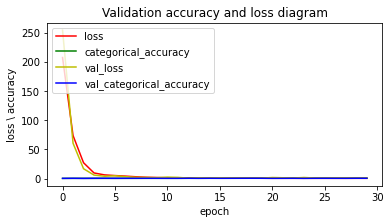

In [12]:
model = getModelVGG16((224,224,3), batchNorm = True, dropout = 0.5, denseLayersSize = 512)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO05_512", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


Epoch 1/30
150/150 [==============================] - 115s 764ms/step - loss: 221.6805 - categorical_accuracy: 0.5273 - val_loss: 194.9515 - val_categorical_accuracy: 0.4675
Epoch 2/30
150/150 [==============================] - 74s 493ms/step - loss: 29.1660 - categorical_accuracy: 0.5746 - val_loss: 11.9333 - val_categorical_accuracy: 0.5825
Epoch 3/30
150/150 [==============================] - 107s 710ms/step - loss: 5.7899 - categorical_accuracy: 0.5517 - val_loss: 7.1349 - val_categorical_accuracy: 0.5725
Epoch 4/30
150/150 [==============================] - 90s 600ms/step - loss: 4.8132 - categorical_accuracy: 0.5608 - val_loss: 6.2669 - val_categorical_accuracy: 0.5825
Epoch 5/30
150/150 [==============================] - 106s 706ms/step - loss: 4.0250 - categorical_accuracy: 0.5688 - val_loss: 3.3607 - val_categorical_accuracy: 0.6225
Epoch 6/30
150/150 [==============================] - 127s 848ms/step - loss: 3.1012 - categorical_accuracy: 0.5956 - val_loss: 3.3284 - val_categ

### Training time: 3236.52s

13/13 [==============================] - 1s 71ms/step - loss: 0.7992 - categorical_accuracy: 0.7475


Model     Time  F1Score                      Loss  Epochs  \
0  logs/5_BN_DO02_512  3236.52     0.75  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.52                  0.82       0.8   

   val_categorical_accuracy  
0                      0.75

precision  recall  f1-score   support
church          0.568047  0.9600  0.713755  100.0000
garbage_truck   0.855422  0.7100  0.775956  100.0000
gas_pump        0.833333  0.7000  0.760870  100.0000
parachute       0.968750  0.6200  0.756098  100.0000
accuracy        0.747500  0.7475  0.747500    0.7475
macro avg       0.806388  0.7475  0.751670  400.0000
weighted avg    0.806388  0.7475  0.751670  400.0000

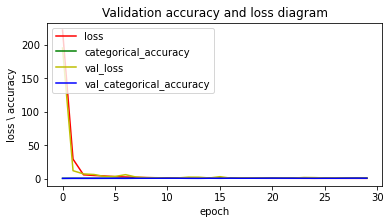

In [13]:
model = getModelVGG16((224,224,3), batchNorm = True, dropout = 0.2, denseLayersSize = 512)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO02_512", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


Epoch 1/30
150/150 [==============================] - 109s 728ms/step - loss: 204.0697 - categorical_accuracy: 0.5304 - val_loss: 81.7032 - val_categorical_accuracy: 0.4675
Epoch 2/30
150/150 [==============================] - 129s 860ms/step - loss: 12.0618 - categorical_accuracy: 0.5423 - val_loss: 8.1068 - val_categorical_accuracy: 0.5650
Epoch 3/30
150/150 [==============================] - 92s 611ms/step - loss: 5.6438 - categorical_accuracy: 0.5265 - val_loss: 6.3830 - val_categorical_accuracy: 0.5775
Epoch 4/30
150/150 [==============================] - 98s 656ms/step - loss: 4.8546 - categorical_accuracy: 0.5575 - val_loss: 4.7060 - val_categorical_accuracy: 0.6050
Epoch 5/30
150/150 [==============================] - 77s 516ms/step - loss: 4.1372 - categorical_accuracy: 0.5754 - val_loss: 4.6051 - val_categorical_accuracy: 0.5725
Epoch 6/30
150/150 [==============================] - 124s 827ms/step - loss: 3.5488 - categorical_accuracy: 0.5908 - val_loss: 3.1710 - val_categori

### Training time: 2999.0s

13/13 [==============================] - 1s 73ms/step - loss: 0.6608 - categorical_accuracy: 0.7950


Model    Time  F1Score                      Loss  Epochs  \
0  logs/6_BN_DO01_512  2999.0      0.8  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.53                  0.81      0.66   

   val_categorical_accuracy  
0                       0.8

precision  recall  f1-score  support
church          0.656934   0.900  0.759494  100.000
garbage_truck   0.894737   0.680  0.772727  100.000
gas_pump        0.765957   0.720  0.742268  100.000
parachute       0.946237   0.880  0.911917  100.000
accuracy        0.795000   0.795  0.795000    0.795
macro avg       0.815966   0.795  0.796602  400.000
weighted avg    0.815966   0.795  0.796602  400.000

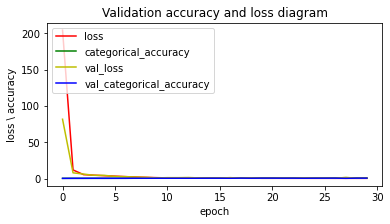

In [14]:
model = getModelVGG16((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 512)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_512", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
  1/600 [..............................] - ETA: 0s - loss: 6.5472 - categorical_accuracy: 0.0000e+00WARNING:tensorflow:From C:\Users\Pijama4WD\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
600/600 [==============================] - 71s 118ms/step - loss: 108.0213 - categorical_accuracy: 0.4677 - val_loss: 20.8497 - val_categorical_accuracy: 0.5050
Epoch 2/30
600/600 [==============================] - 65s 108ms/step - loss: 10.9170 - categorical_accuracy: 0.5038 - val_loss: 10.3887 - val_categorical_accuracy: 0.5700
Epoch 3/30
600/600 [==============================] - 50s 83ms/step - loss: 6.1749 - categorical_accuracy: 0.5108 - val_loss: 3.9310 - val_categori

### Training time: 1568.95s

50/50 [==============================] - 1s 20ms/step - loss: 0.9674 - categorical_accuracy: 0.7025


Model     Time  F1Score                      Loss  Epochs  \
0  logs/7_BN_DO01_BS8  1568.95     0.68  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.61                  0.78      0.97   

   val_categorical_accuracy  
0                       0.7

precision  recall  f1-score   support
church          0.595745  0.8400  0.697095  100.0000
garbage_truck   0.931034  0.2700  0.418605  100.0000
gas_pump        0.625000  0.8500  0.720339  100.0000
parachute       0.904255  0.8500  0.876289  100.0000
accuracy        0.702500  0.7025  0.702500    0.7025
macro avg       0.764009  0.7025  0.678082  400.0000
weighted avg    0.764009  0.7025  0.678082  400.0000

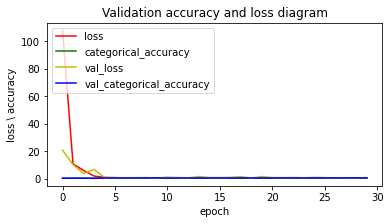

In [6]:
model = getModelVGG16((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 512)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_BS8", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
150/150 [==============================] - 54s 362ms/step - loss: 155.1358 - categorical_accuracy: 0.5296 - val_loss: 93.3450 - val_categorical_accuracy: 0.5950
Epoch 2/30
150/150 [==============================] - 49s 326ms/step - loss: 17.4127 - categorical_accuracy: 0.5815 - val_loss: 5.0700 - val_categorical_accuracy: 0.5625
Epoch 3/30
150/150 [==============================] - 49s 328ms/step - loss: 3.2398 - categorical_accuracy: 0.5537 - val_loss: 2.6477 - val_categorical_accuracy: 0.6375
Epoch 4/30
150/150 [==============================] - 49s 323ms/step - loss: 2.5959 - categorical_accuracy: 0.5750 - val_loss: 5.7481 - val_categorical_accuracy: 0.5425
Epoch 5/30
150/150 [==============================] - 49s 324ms/step - loss: 2.3181 - categorical_accuracy: 0.5800 - val_loss: 3.1088 - val_categorical_accuracy: 0.6000
Epoch 6/30
150/150 [=======

### Training time: 1498.94s

13/13 [==============================] - 1s 68ms/step - loss: 0.7139 - categorical_accuracy: 0.7625


Model     Time  F1Score                      Loss  Epochs  \
0  logs/8_BN_DO01_D256  1498.94     0.76  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.49                  0.82      0.71   

   val_categorical_accuracy  
0                      0.76

precision  recall  f1-score   support
church          0.724409  0.9200  0.810573  100.0000
garbage_truck   0.978261  0.4500  0.616438  100.0000
gas_pump        0.615385  0.8800  0.724280  100.0000
parachute       0.952381  0.8000  0.869565  100.0000
accuracy        0.762500  0.7625  0.762500    0.7625
macro avg       0.817609  0.7625  0.755214  400.0000
weighted avg    0.817609  0.7625  0.755214  400.0000

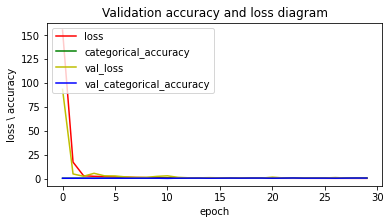

In [7]:
model = getModelVGG16((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 256)
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 32, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_D256", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


In [7]:
def getModelVGG16_V2(input_shape, batchNorm = True, dropout = 0.2, denseLayersSize = 512, kr=0.0001, pooling='max'):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(filters=32,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv1",kernel_initializer="glorot_uniform", padding='same',strides=(1,1), kernel_regularizer=regularizers.l2(kr)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=32,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv2",kernel_initializer="glorot_uniform", padding='same',strides=(1,1), kernel_regularizer=regularizers.l2(kr)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    if (pooling =='max'):
        model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPool1"))
    else:
        model.add(layers.AveragePooling2D(pool_size=(2,2), name="AvgPool1"))

    if (dropout > 0):
        model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(filters=64,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv3",kernel_initializer="glorot_uniform", padding='same',strides=(1,1), kernel_regularizer=regularizers.l2(kr)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=64,kernel_size=(3,3), dilation_rate=1, activation="relu", name="Conv4",kernel_initializer="glorot_uniform", padding='same',strides=(1,1), kernel_regularizer=regularizers.l2(kr)))
    if (batchNorm == True):
        model.add(layers.BatchNormalization())

    if (pooling =='max'):
        model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPool2"))
    else:
        model.add(layers.AveragePooling2D(pool_size=(2,2), name="AvgPool2"))

    if (dropout > 0):
        model.add(layers.Dropout(dropout))

    model.add(layers.Flatten(name="Flatten1"))
    model.add(layers.Dense(denseLayersSize,kernel_initializer="glorot_uniform",name="FC1"))
    if (dropout > 0):
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(4, activation="softmax", name="output",kernel_initializer="glorot_uniform"))

    return model

'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
  1/600 [..............................] - ETA: 0s - loss: 5.3352 - categorical_accuracy: 0.1250WARNING:tensorflow:From C:\Users\Pijama4WD\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
600/600 [==============================] - 57s 96ms/step - loss: 98.3515 - categorical_accuracy: 0.4683 - val_loss: 19.0230 - val_categorical_accuracy: 0.4975
Epoch 2/30
600/600 [==============================] - 50s 84ms/step - loss: 11.9735 - categorical_accuracy: 0.4917 - val_loss: 13.9378 - val_categorical_accuracy: 0.4825
Epoch 3/30
600/600 [==============================] - 50s 83ms/step - loss: 6.9433 - categorical_accuracy: 0.5290 - val_loss: 4.7616 - val_categorical_acc

### Training time: 1552.68s

50/50 [==============================] - 1s 21ms/step - loss: 0.8172 - categorical_accuracy: 0.7175


Model     Time  F1Score                      Loss  Epochs  \
0  logs/9_BN_DO01_BS8_KR4  1552.68     0.71  categorical_crossentropy      30   

                     Metrics  loss  categorical_accuracy  val_loss  \
0  loss categorical_accuracy  0.84                  0.72      0.82   

   val_categorical_accuracy  
0                      0.72

precision  recall  f1-score   support
church          0.633588  0.8300  0.718615  100.0000
garbage_truck   0.841270  0.5300  0.650307  100.0000
gas_pump        0.762500  0.6100  0.677778  100.0000
parachute       0.714286  0.9000  0.796460  100.0000
accuracy        0.717500  0.7175  0.717500    0.7175
macro avg       0.737911  0.7175  0.710790  400.0000
weighted avg    0.737911  0.7175  0.710790  400.0000

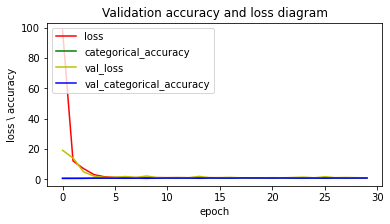

In [9]:
model = getModelVGG16_V2((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 512)

model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=['categorical_accuracy'])

#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_BS8_KR4", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
600/600 [==============================] - 57s 94ms/step - loss: 68.2241 - categorical_accuracy: 0.5346 - val_loss: 39.8377 - val_categorical_accuracy: 0.6550
Epoch 2/30
600/600 [==============================] - 51s 86ms/step - loss: 34.7598 - categorical_accuracy: 0.5940 - val_loss: 22.8424 - val_categorical_accuracy: 0.6425
Epoch 3/30
600/600 [==============================] - 52s 87ms/step - loss: 14.8505 - categorical_accuracy: 0.6173 - val_loss: 7.9037 - val_categorical_accuracy: 0.6600
Epoch 4/30
600/600 [==============================] - 51s 85ms/step - loss: 4.1454 - categorical_accuracy: 0.6346 - val_loss: 1.5873 - val_categorical_accuracy: 0.6550
Epoch 5/30
600/600 [==============================] - 51s 85ms/step - loss: 1.2559 - categorical_accuracy: 0.6592 - val_loss: 1.0709 - val_categorical_accuracy: 0.6525
Epoch 6/30
600/600 [===========

### Training time: 1552.55s

50/50 [==============================] - 1s 20ms/step - loss: 1.0745 - categorical_accuracy: 0.7225


Model     Time  F1Score  \
0  logs/10_8_BN_DO01_D256_kr3_lr0002_m01  1552.55     0.72   

                       Loss  Epochs                    Metrics  loss  \
0  categorical_crossentropy      30  loss categorical_accuracy  0.68   

   categorical_accuracy  val_loss  val_categorical_accuracy  
0                   0.8      1.07                      0.72

precision  recall  f1-score   support
church          0.528090  0.9400  0.676259  100.0000
garbage_truck   0.870968  0.5400  0.666667  100.0000
gas_pump        0.782609  0.5400  0.639053  100.0000
parachute       0.956044  0.8700  0.910995  100.0000
accuracy        0.722500  0.7225  0.722500    0.7225
macro avg       0.784428  0.7225  0.723243  400.0000
weighted avg    0.784428  0.7225  0.723243  400.0000

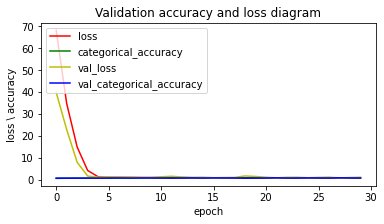

In [11]:
model = getModelVGG16_V2((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 256, kr=0.001)

train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)
rmsPropOptimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002,momentum=0.1,epsilon=1e-07)

model.compile(loss="categorical_crossentropy",optimizer=rmsPropOptimizer,metrics=['categorical_accuracy'])



#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/8_BN_DO01_D256_kr3_lr0002_m01", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
  1/600 [..............................] - ETA: 0s - loss: 3.8607 - categorical_accuracy: 0.0000e+00WARNING:tensorflow:From C:\Users\Pijama4WD\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
600/600 [==============================] - 55s 91ms/step - loss: 22.5193 - categorical_accuracy: 0.5402 - val_loss: 15.2143 - val_categorical_accuracy: 0.6025
Epoch 2/30
600/600 [==============================] - 50s 83ms/step - loss: 7.6721 - categorical_accuracy: 0.5883 - val_loss: 4.3430 - val_categorical_accuracy: 0.5575
Epoch 3/30
600/600 [==============================] - 51s 84ms/step - loss: 1.8478 - categorical_accuracy: 0.6263 - val_loss: 1.2442 - val_categorical_a

### Training time: 1559.4s

50/50 [==============================] - 1s 21ms/step - loss: 1.1452 - categorical_accuracy: 0.6900


Model    Time  F1Score  \
0  logs/11_BN_DO01_D256_kr3_lr0002_m01_AvgP  1559.4     0.69   

                       Loss  Epochs                    Metrics  loss  \
0  categorical_crossentropy      30  loss categorical_accuracy  0.63   

   categorical_accuracy  val_loss  val_categorical_accuracy  
0                  0.81      1.15                      0.69

precision  recall  f1-score  support
church          0.528090    0.94  0.676259   100.00
garbage_truck   0.866667    0.52  0.650000   100.00
gas_pump        0.680000    0.68  0.680000   100.00
parachute       1.000000    0.62  0.765432   100.00
accuracy        0.690000    0.69  0.690000     0.69
macro avg       0.768689    0.69  0.692923   400.00
weighted avg    0.768689    0.69  0.692923   400.00

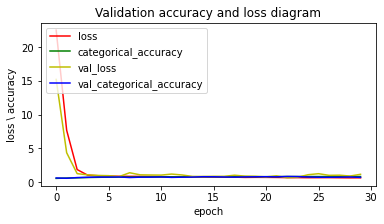

In [8]:
model = getModelVGG16_V2((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 256, kr=0.001, pooling='avg')

train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)
rmsPropOptimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002,momentum=0.1,epsilon=1e-07)

model.compile(loss="categorical_crossentropy",optimizer=rmsPropOptimizer,metrics=['categorical_accuracy'])



#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_D256_kr3_lr0002_m01_AvgP", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
600/600 [==============================] - 57s 95ms/step - loss: 47.9099 - categorical_accuracy: 0.4519 - val_loss: 8.6371 - val_categorical_accuracy: 0.4525
Epoch 2/30
600/600 [==============================] - 52s 87ms/step - loss: 9.6071 - categorical_accuracy: 0.4742 - val_loss: 9.1734 - val_categorical_accuracy: 0.5000
Epoch 3/30
600/600 [==============================] - 52s 86ms/step - loss: 7.0408 - categorical_accuracy: 0.5088 - val_loss: 3.8658 - val_categorical_accuracy: 0.5700
Epoch 4/30
600/600 [==============================] - 52s 87ms/step - loss: 2.3948 - categorical_accuracy: 0.5502 - val_loss: 1.4027 - val_categorical_accuracy: 0.6500
Epoch 5/30
600/600 [==============================] - 52s 86ms/step - loss: 1.2547 - categorical_accuracy: 0.6223 - val_loss: 1.1006 - val_categorical_accuracy: 0.6800
Epoch 6/30
600/600 [===============

### Training time: 1565.58s

50/50 [==============================] - 1s 21ms/step - loss: 0.7643 - categorical_accuracy: 0.7750


Model     Time  F1Score  \
0  logs/12_BN_DO01_D256_kr3_lr0002_Adam_AvgP  1565.58     0.77   

                       Loss  Epochs                    Metrics  loss  \
0  categorical_crossentropy      30  loss categorical_accuracy  0.92   

   categorical_accuracy  val_loss  val_categorical_accuracy  
0                  0.71      0.76                      0.77

precision  recall  f1-score  support
church          0.666667   0.840  0.743363  100.000
garbage_truck   0.738739   0.820  0.777251  100.000
gas_pump        0.857143   0.600  0.705882  100.000
parachute       0.903226   0.840  0.870466  100.000
accuracy        0.775000   0.775  0.775000    0.775
macro avg       0.791444   0.775  0.774241  400.000
weighted avg    0.791444   0.775  0.774241  400.000

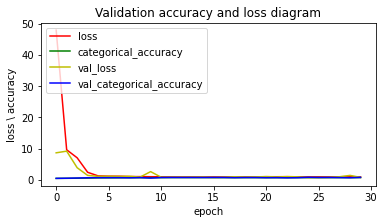

In [9]:
model = getModelVGG16_V2((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 256, kr=0.001, pooling='avg')
adamPropOptimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss="categorical_crossentropy",optimizer=adamPropOptimizer,metrics=['categorical_accuracy'])

#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_D256_kr3_lr0002_Adam_AvgP", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
600/600 [==============================] - 64s 107ms/step - loss: 39.0629 - categorical_accuracy: 0.5258 - val_loss: 1.6248 - val_categorical_accuracy: 0.5875
Epoch 2/30
600/600 [==============================] - 53s 89ms/step - loss: 1.6225 - categorical_accuracy: 0.5804 - val_loss: 1.7564 - val_categorical_accuracy: 0.6575
Epoch 3/30
600/600 [==============================] - 52s 87ms/step - loss: 1.7815 - categorical_accuracy: 0.5888 - val_loss: 1.6582 - val_categorical_accuracy: 0.6225
Epoch 4/30
600/600 [==============================] - 53s 88ms/step - loss: 2.0745 - categorical_accuracy: 0.5702 - val_loss: 2.0770 - val_categorical_accuracy: 0.5575
Epoch 5/30
600/600 [==============================] - 53s 88ms/step - loss: 1.9566 - categorical_accuracy: 0.5706 - val_loss: 1.7701 - val_categorical_accuracy: 0.6000
Epoch 6/30
600/600 [==============

### Training time: 1607.49s

50/50 [==============================] - 1s 21ms/step - loss: 0.7335 - categorical_accuracy: 0.7975


Model     Time  F1Score  \
0  logs/13_BN_DO01_D256_kr3_lr0001_Adam_AvgP  1607.49      0.8   

                       Loss  Epochs                    Metrics  loss  \
0  categorical_crossentropy      30  loss categorical_accuracy  0.73   

   categorical_accuracy  val_loss  val_categorical_accuracy  
0                  0.77      0.73                       0.8

precision  recall  f1-score   support
church          0.743119  0.8100  0.775120  100.0000
garbage_truck   0.842697  0.7500  0.793651  100.0000
gas_pump        0.802198  0.7300  0.764398  100.0000
parachute       0.810811  0.9000  0.853081  100.0000
accuracy        0.797500  0.7975  0.797500    0.7975
macro avg       0.799706  0.7975  0.796562  400.0000
weighted avg    0.799706  0.7975  0.796562  400.0000

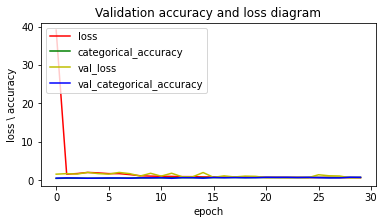

In [10]:
model = getModelVGG16_V2((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 256, kr=0.001, pooling='avg')
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)
adamPropOptimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="categorical_crossentropy",optimizer=adamPropOptimizer,metrics=['categorical_accuracy'])

#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_D256_kr3_lr0001_Adam_AvgP", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
600/600 [==============================] - 71s 119ms/step - loss: 31.3119 - categorical_accuracy: 0.5081 - val_loss: 2.9090 - val_categorical_accuracy: 0.5675
Epoch 2/30
600/600 [==============================] - 74s 123ms/step - loss: 3.5006 - categorical_accuracy: 0.5315 - val_loss: 3.4012 - val_categorical_accuracy: 0.6050
Epoch 3/30
600/600 [==============================] - 74s 123ms/step - loss: 3.9187 - categorical_accuracy: 0.5421 - val_loss: 4.6840 - val_categorical_accuracy: 0.6150
Epoch 4/30
600/600 [==============================] - 75s 125ms/step - loss: 4.3482 - categorical_accuracy: 0.5290 - val_loss: 3.4346 - val_categorical_accuracy: 0.6300
Epoch 5/30
600/600 [==============================] - 52s 86ms/step - loss: 3.9823 - categorical_accuracy: 0.5471 - val_loss: 3.4843 - val_categorical_accuracy: 0.5375
Epoch 6/30
600/600 [===========

### Training time: 1680.62s

50/50 [==============================] - 1s 22ms/step - loss: 0.8433 - categorical_accuracy: 0.7325


Model     Time  F1Score  \
0  logs/14_BN_DO01_D512_kr3_lr0001_Adam_AvgP  1680.62     0.74   

                       Loss  Epochs                    Metrics  loss  \
0  categorical_crossentropy      30  loss categorical_accuracy  0.77   

   categorical_accuracy  val_loss  val_categorical_accuracy  
0                  0.75      0.84                      0.73

precision  recall  f1-score   support
church          0.530387  0.9600  0.683274  100.0000
garbage_truck   0.919355  0.5700  0.703704  100.0000
gas_pump        0.828571  0.5800  0.682353  100.0000
parachute       0.942529  0.8200  0.877005  100.0000
accuracy        0.732500  0.7325  0.732500    0.7325
macro avg       0.805210  0.7325  0.736584  400.0000
weighted avg    0.805210  0.7325  0.736584  400.0000

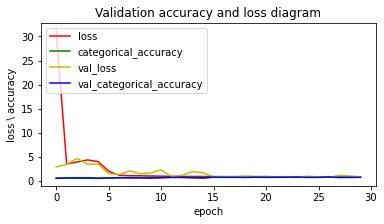

In [11]:
model = getModelVGG16_V2((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 512, kr=0.001, pooling='avg')
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)
adamPropOptimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="categorical_crossentropy",optimizer=adamPropOptimizer,metrics=['categorical_accuracy'])

#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_D512_kr3_lr0001_Adam_AvgP", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


'This is using data augumentation.'

Found 4800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/30
  1/600 [..............................] - ETA: 0s - loss: 2.7724 - categorical_accuracy: 0.2500WARNING:tensorflow:From C:\Users\Pijama4WD\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
600/600 [==============================] - 60s 100ms/step - loss: 73.0641 - categorical_accuracy: 0.4992 - val_loss: 4.5426 - val_categorical_accuracy: 0.5800
Epoch 2/30
600/600 [==============================] - 73s 121ms/step - loss: 6.6769 - categorical_accuracy: 0.5263 - val_loss: 9.4088 - val_categorical_accuracy: 0.6025
Epoch 3/30
600/600 [==============================] - 51s 85ms/step - loss: 12.5278 - categorical_accuracy: 0.5017 - val_loss: 17.7176 - val_categorical_ac

### Training time: 1715.28s

50/50 [==============================] - 1s 22ms/step - loss: 1.1957 - categorical_accuracy: 0.6825


Model     Time  F1Score  \
0  logs/15_BN_DO01_D512_kr3_lr0001_Adam_Max  1715.28     0.66   

                       Loss  Epochs                    Metrics  loss  \
0  categorical_crossentropy      30  loss categorical_accuracy  0.73   

   categorical_accuracy  val_loss  val_categorical_accuracy  
0                  0.77       1.2                      0.68

precision  recall  f1-score   support
church          0.558824  0.9500  0.703704  100.0000
garbage_truck   0.960000  0.2400  0.384000  100.0000
gas_pump        0.601695  0.7100  0.651376  100.0000
parachute       0.954023  0.8300  0.887701  100.0000
accuracy        0.682500  0.6825  0.682500    0.6825
macro avg       0.768635  0.6825  0.656695  400.0000
weighted avg    0.768635  0.6825  0.656695  400.0000

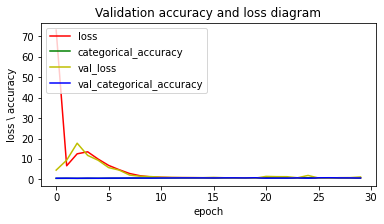

In [9]:
model = getModelVGG16_V2((224,224,3), batchNorm = True, dropout = 0.1, denseLayersSize = 512, kr=0.001, pooling='max')
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)
adamPropOptimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="categorical_crossentropy",optimizer=adamPropOptimizer,metrics=['categorical_accuracy'])

#Get generators with the TRAIN with image size of 280,  data augumentation,  and size batch of 1
train_images, validation_images, test_images = CreateImageDataGenerators(224, 8, use_data_aug = True)

#The name is Keas is BN_DO01_D512_kr3_lr0001_Adam_AvgP, it is wrong.
tbch = tbh.TensorBoardCallBackHelper(model, logDir = "logs/BN_DO01_D512_kr3_lr0001_Adam_Max", test_data_generator = validation_images, modelCheckPointMonitor = 'val_categorical_accuracy')

with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    #Note the baseline version is trained with no data augumentation
    model.fit(train_images, validation_data = validation_images, epochs=EPOCHS, callbacks=[tbch.callbacks])


In [7]:
from keras_flops import get_flops
from keras.models import load_model
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Flops for the baseline model
model = load_model('D:\\MyWorkSpace\\dcu_cv_assignment_ee544\\ModelsH5\\Vgg16_Baseline.h5')
flops = get_flops(model, batch_size=1)
print(f"FLOPS for VGG 16 baseline: {flops / 10 ** 9:.03} G")

#Flops for the improved model
model = load_model('D:\\MyWorkSpace\\dcu_cv_assignment_ee544\\ModelsH5\\Vgg16_ImprovedModel.h5')
flops = get_flops(model, batch_size=1)
print(f"FLOPS for VGG 16 Improved version: {flops / 10 ** 9:.03} G")

#Final accuracy and loss for the improved model over the test set
train_images, validation_images, test_images = CreateImageDataGenerators(224, 32, use_data_aug = False)
score = model.evaluate(test_images, verbose = 0)

print('Test loss:', round(score[0],2)) 
print('Test accuracy:',  round(score[1],2))

#Print confusion matrix for the test set
test_pred_raw = model.predict(test_images)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = sklearn.metrics.confusion_matrix(test_images.labels, test_pred)

class_names = list(test_images.class_indices.keys())
cm_image = tbh.plot_confusion_matrix(cm, class_names,True) #not display during the epoch

None

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS for VGG 16 baseline: 2.61 G
FLOPS for VGG 16 Improved version: 2.52 G
